In [65]:
import numpy as np
import pandas as pd
from utils import black_scholes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import time, timeit

$$ v(x,t_0) \approx v_3(x,t_0) = e^{-r\Delta t} {\sum_{k=0}^{N-1}} ^{'}  \text{Re} \left \{ \phi \left(\frac{k\pi}{b-a} ; x\right) e^{ik\pi \frac{a}{b-a}} \right \}V_k  $$

**Mathematical Derivation**

$$G_k  = \frac{2}{b-a} K (\chi_k(0,b) - \psi_k(0,b))$$

where $\chi_{k}(a, b)$ and $\psi_{k}(a, b)$ are given as:
$$
\begin{aligned}
\chi_{k}(c, d):=& \frac{1}{1+\left(\frac{k \pi}{b-a}\right)^{2}}\left[\cos \left(k \pi \frac{d-a}{b-a}\right) e^{d}-\cos \left(k \pi \frac{c-a}{b-a}\right) e^{c}\right.\\
&\left.+\frac{k \pi}{b-a} \sin \left(k \pi \frac{d-a}{b-a}\right) e^{d}-\frac{k \pi}{b-a} \sin \left(k \pi \frac{c-a}{b-a}\right) e^{c}\right], \\
\psi_{k}(c, d):=&\left\{\begin{array}{ll}
{\left[\sin \left(k \pi \frac{d-a}{b-a}\right)-\sin \left(k \pi \frac{c-a}{b-a}\right)\right] \frac{b-a}{k \pi}} & \text { if } k \neq 0 \\
d-c & \text { if } k=0 .
\end{array}\right.
\end{aligned}
$$


Then we can approximate $V (x, t)$ by a finite sum of Fourier cosine coefficients $F_n$ and $G_n$ of the conditional density function and payoff function respectively as:

$$ V(x,t) = e^{-rT} {\sum_{k=0}^{N}}  F_k(x) G_k $$

Question is:

Is $F_k$ given by: $$\text{Re} \left \{ \phi \left(\frac{k\pi}{b-a} ; x\right) e^{ik\pi \frac{a}{b-a}} \right \} $$ 

Where $\phi$ is the charcteristic equation which is
$$ \phi(u) = e^{iu(r-0.5*\sigma^2)T -(0.5*\sigma^2 T u^2)}$$

In [2]:


def Chi(a,b,c,d,k):
   first = np.cos(k*np.pi*(d-a)/(b-a)) *np.exp(d) 
   second = np.cos(k*np.pi*(c-a)/(b-a))*np.exp(c)
   third = ((k*np.pi)/(b-a)) * np.sin(k*np.pi*(d-a)/(b-a)) *np.exp(d) 
   fourth = ((k*np.pi)/(b-a)) * np.sin(k*np.pi*(c-a)/(b-a))*np.exp(c)

   coefficient = 1/(1+ ((k*np.pi)/(b-a) )**2 )
   return coefficient*(first - second + third - fourth)


def Psi(a,b,c,d,k):
   if k == 0:
      result = d-c
   elif k>0:
      first_sin = np.sin(k*np.pi*((d-a)/(b-a)))
      second_sin = np.sin(k*np.pi*((c-a)/(b-a)))

      result = ((b-a)/(k*np.pi))*(first_sin - second_sin)
   else:
      raise ValueError('k is less than 0')
   return result

def G_call(a,b,K,k):
    c,d =0, b
    return (2/(b-a))*K*(Chi(a,b,c,d,k) - Psi(a,b,c,d,k))
    
def G_put(a,b,K,k):
    c,d =a, 0
    return (2/(b-a))*K*(-Chi(a,b,c,d,k) + Psi(a,b,c,d,k))



j = complex(0,1)

def char_func(u,r,T,sigma):
   phi = np.exp((T)*(j*u*(r-(sigma**2)/2) -(((sigma**2)/2) * (u**2)) ) )*np.exp(j*u*x)
   return phi

def func_n(r,T,sigma,k):
    F_n =  np.real(char_func(k*np.pi/(b-a),r,T,sigma)*np.exp((-j*k*a*np.pi)/(b-a)) )
    return F_n


def CosMethod(K,r,T,sigma,k,option_type):
   if option_type == 'Put':
      values = [0.5*func_n(r,T,sigma,0)*G_put(a,b,K,k =0)]
      
      for i in range(1,k+1):
         value = func_n(r,T,sigma,k=i)*G_put(a,b,K,k =i)
         values.append(value)
      return np.exp(-r*T)*sum(values),values

   values = [0.5*func_n(r,T,sigma,0)*G_call(a,b,K,k =0)]
   for i in range(1,k+1):
      value = func_n(r,T,sigma,k=i)*G_call(a,b,K,k=i)
      values.append(value)
   return np.exp(-r*T)*sum(values),values

In [125]:

# S_0,K,r,T,sigma = 100,99,0.04,365/365,0.2

# x= np.log(S_0/K)
# a,b= x + r*T - 12*np.sqrt(T*(sigma**2)),x + r*T + 12*np.sqrt(T*(sigma**2))

# bsPut,bsCall =black_scholes.putBlackScholes(S_0,T, r, K, sigma),black_scholes.callBlackScholes(S_0,T, r, K, sigma)[0]
# cosPut,cosCall = CosMethod(K,r,T,sigma ,k=64, option_type='Put')[0],CosMethod(K,r,T,sigma ,k=300, option_type='call')[0]

# print(f'Methods: Black-Scholes, Cos Method\nCalls: {bsCall},{cosCall}\nPuts: {bsPut},{cosPut}')
# print(f'Parameters, S_0 = {S_0}, K = {K}, r = {r}, T = {T}, sigma = {sigma}' )



S_0,K,r,T,sigma = 100,110,0.04,365/365,0.3

x= np.log(S_0/K)
a,b= x + r*T - 12*np.sqrt(T*(sigma**2)),x + r*T + 12*np.sqrt(T*(sigma**2))

bsPut,bsCall =black_scholes.putBlackScholes(S_0,T, r, K, sigma),black_scholes.callBlackScholes(S_0,T, r, K, sigma)[0]
cosPut,cosCall = CosMethod(K,r,T,sigma ,k=64, option_type='Put')[0],CosMethod(K,r,T,sigma ,k=300, option_type='call')[0]
cosValues = CosMethod(K,r,T,sigma ,k=300, option_type='call')[1]

print(f'Different parameters test\nMethods: Black-Scholes, Cos Method\nCalls: {bsCall},{cosCall}\nPuts: {bsPut},{cosPut}')
print(f'Parameters, S_0 = {S_0}, K = {K}, r = {r}, T = {T}, sigma = {sigma}' )



Different parameters test
Methods: Black-Scholes, Cos Method
Calls: 9.625357828843697,9.625357828842999
Puts: 15.312196135599244,15.312196135599192
Parameters, S_0 = 100, K = 110, r = 0.04, T = 1.0, sigma = 0.3


In [126]:
bsCall =black_scholes.callBlackScholes(S_0,T, r, K, sigma)[0]

absErrors = {}
relErrors = {}
callValues = {}

for i in range(200):
    val = CosMethod(K,r,T,sigma ,k=i, option_type='call')[0]
    diff = val - bsCall
    rel = abs(val/bsCall -1) 
    absErrors[i] = diff
    relErrors[i] = 100*rel
    callValues[i] = val




In [127]:
absErrorDF = pd.DataFrame({'Option price':callValues.values(),'Absolute error': absErrors.values(), 'Relative errors': relErrors.values() })
# relErrorDF = pd.DataFrame(relErrors.values())

# absErrorDF['rel'] = relErrorDF
absErrorDF = absErrorDF.round(6)
absErrorDF.index.name = 'Fourier Coefficients'


absErrorDF[15:30:1]



,Option price,Absolute error,Relative errors
Fourier Coefficients,,,
15,8.536515,-1.088843,11.312232
16,10.650358,1.025000,10.648960
17,10.157996,0.532638,5.533700
18,9.186740,-0.438618,4.556901
19,9.431682,-0.193676,2.012139
20,9.817640,0.192282,1.997661
21,9.709841,0.084483,0.877716
22,9.549394,-0.075964,0.789210
23,9.597146,-0.028212,0.293102


Text(0.5, 0, 'Number of coefficients')

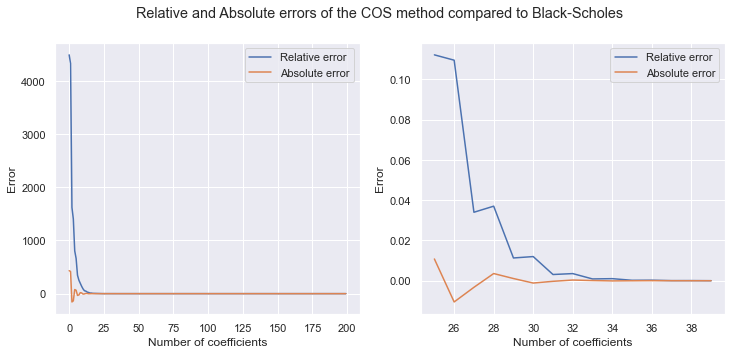

In [128]:
#Errors plot

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False, sharex=False)
fig.suptitle('Relative and Absolute errors of the COS method compared to Black-Scholes')

axes[0].plot(absErrorDF['Relative errors'], label ='Relative error' )
axes[0].plot(absErrorDF['Absolute error'], label ='Absolute error' )


axes[1].plot(absErrorDF['Relative errors'][25:40], label ='Relative error' )
axes[1].plot(absErrorDF['Absolute error'][25:40], label ='Absolute error')

axes[0].legend()
axes[1].legend()
axes[0].set_ylabel('Error')
axes[0].set_xlabel('Number of coefficients')
axes[1].set_ylabel('Error')
axes[1].set_xlabel('Number of coefficients')

Text(0.5, 0, 'Number of coefficients')

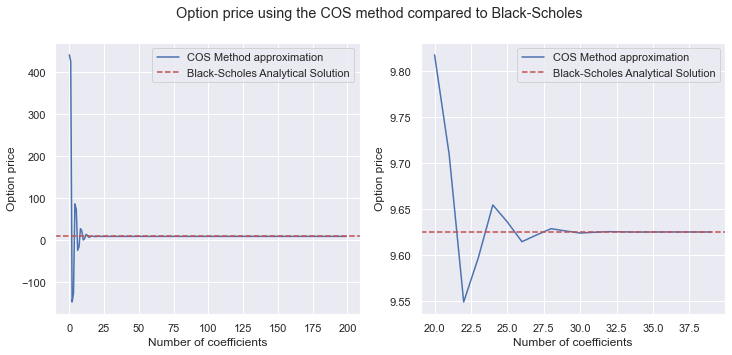

In [129]:
#Value plot

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False, sharex=False)
fig.suptitle('Option price using the COS method compared to Black-Scholes')

axes[0].plot(absErrorDF['Option price'], label ='COS Method approximation' )
axes[0].axhline(bsCall, color ='r',  linestyle = '--', label = "Black-Scholes Analytical Solution")


axes[1].plot(absErrorDF['Option price'][20:40:1], label ='COS Method approximation' )
axes[1].axhline(bsCall, color ='r',  linestyle = '--', label = "Black-Scholes Analytical Solution")

axes[0].legend()
axes[1].legend()
axes[0].set_ylabel('Option price')
axes[0].set_xlabel('Number of coefficients')
axes[1].set_ylabel('Option price')
axes[1].set_xlabel('Number of coefficients')


# plt.plot(absErrorDF['Option price'], label ='COS Method approximation' )
# plt.axhline(bsCall, color ='r',  linestyle = '--')

# plt.title('Option price using the COS method compared to Black-Scholes')

# plt.legend()
# plt.xlabel('Number of coefficients')
# plt.ylabel('Price')

Text(0, 0.5, 'Price')

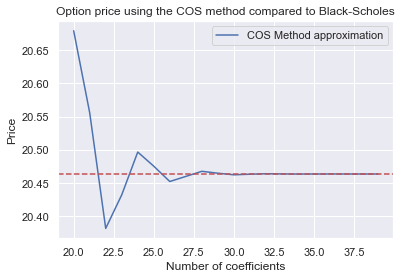

In [57]:

plt.plot(absErrorDF['Option price'][20:40:1], label ='COS Method approximation' )
plt.axhline(bsCall, color ='r',  linestyle = '--')

plt.title('Option price using the COS method compared to Black-Scholes')

plt.legend()
plt.xlabel('Number of coefficients')
plt.ylabel('Price')

### Error analysis and computation time

In [131]:
bsCall =black_scholes.callBlackScholes(S_0,T, r, K, sigma)[0]

absErrors = {}
relErrors = {}
callValues = {}
times = {}

grid = [16,32,64,96,128,160,196]

for i in grid:
    val = CosMethod(K,r,T,sigma ,k=i, option_type='call')[0]
    diff = val - bsCall
    rel = abs(val/bsCall -1) 
    absErrors[i] = diff
    relErrors[i] = 100*rel
    callValues[i] = val

    t =timeit.Timer(lambda: CosMethod(K,r,T,sigma ,k=i, option_type='call')[0])
    times[i]= t.timeit(2)


err_time_df = pd.DataFrame({'Computation time':times , 'Error (%)':relErrors})
err_time_df['Computation time'] = err_time_df['Computation time'].round(6)
err_time_df.index.name = 'Number of coefficients'
err_time_df = err_time_df.T

In [124]:


t =timeit.Timer(lambda: black_scholes.callBlackScholes(S_0,T, r, K, sigma)[0]) 
t.timeit(1)
# import timeit, functools
# t = timeit.Timer(functools.partial(foo, A, B)) 
# print(t.timeit(5))

0.0005481739999595447

In [132]:
# print(err_time_df.to_latex)

print(err_time_df.to_latex(index=True))

\begin{tabular}{lrrrrrrr}
\toprule
Number of coefficients &        16  &       32  &           64  &           96  &           128 &           160 &           196 \\
\midrule
Computation time &   0.002699 &  0.004250 &  9.164000e-03 &  2.643300e-02 &  1.750200e-02 &  2.281300e-02 &  4.059900e-02 \\
Error (\%)        &  10.648960 &  0.003539 &  7.249756e-12 &  7.249756e-12 &  7.249756e-12 &  7.249756e-12 &  7.249756e-12 \\
\bottomrule
\end{tabular}



In [123]:
times

{16: 0.002513725999961025,
 24: 0.0037500620001083007,
 32: 0.006857114000013098,
 64: 0.008352242000000842,
 96: 0.021027209999374463,
 128: 0.027496248999341333,
 160: 0.02257965199987666,
 196: 0.03627963400049339}